# Introduction

The previous version of the algorithm did not have sufficiently tight bounds. Hopefully this version will improve on this. We explain the algorithm, then implement it, step by step in the notebook below.

1) Consider the GP prediction as the sum of exponentiated quadratics centred on all the training points.
2) Split the world into hypercubes.
3) Consider one dimension d.
4) Find how much each of the EQs changes over a given dimension (d) within each hypercube, effectively we just evaluate each EQ in the one dimension (d) at the start and end of the hypercube. We use these 'integrals' (of the derivative over d) as the peak values in the following mixture of Gaussians... we call this result $D^{all}$. Note that the locations can lie outside the hypercube, in the non-d dimensions.
5) Repeat the above but subtract the maximum of the EQ (e.g. if it has a peak that is inside the hypercube this will be different from the result in step 4) from its minimum. We again use these differences as peak values in the following... we call this $D^+$

6) We reintroduce the other dimensions of the hypercube. We can imagine the total change made to the predictions over the d-1 plane (of remaining dimensions) by moving a $d-1$ plane from one side of the hypercube to the other (along dimension d). This can be represented as a series of gaussians (EQs), each centred at one of the training points.

<pre>
d=2 example, n=3.        ------> sum of EQs   
                       |    .
                       |      .
      x                |       .  <-x
 ______________        |__   .
|              |  ,    |  .
|        o     | /|\   | .        <-o
|              |  |    |   .
|   x          |  |    |      .   <-x maximum within bounds of hypercube
|______________|  |z   |__   .
  ---------> d         |   .
                       |  .
                       | .

training points
x with weight = 1
o with weight = -1
</pre>

In the figure, imagine the distribution along the other axis (z) - it will be three EQs over one ($d-1$) dimensions. This sum will be the sum of three EQs (of d-1) dimensions centred at the locations of the training points (with the dth dimension removed).

7) We want to find the largest change possible in the prediction by moving along the d-axis, over the hypercube, both if we've stopped the integration somewhere within it, or if the integration was over the whole cube. Hence we needed the two results (from 4 and 5)...
8) We therefore will later be interested in the largest value in the $d-1$ space of this sum of gaussians. We will also be interested in the case in which the negative EQs are removed.

9) We next consider lists of hypercubes that one needs to pass through to get from the start to the end of dimension d. E.g. in this figure you need to pass through for example C, I, D and H. A full list of possible combinations will need to be made, e.g.:
<pre>
C I D H
C I D G
B D G
B D F
..etc

 ________________
|    |  |    |  |
| b  | d|    |H |
|   C|I | D  |_f|
|____|__|  e |G |
|   B c |    |__|
|_______|____|F |
|            |__|
xa   x  H    |E |
|____________|__|
0 1 2 3 4 5 6 7 8

Where A-I are the 9 hypercuboids, a-f are the peaks of the EQs.</pre>

10) For each list we need to consider all possible start and ends, for the first list the possible combinations are:
<pre>
C->C
C->I
C->D
C->H
I->I
I->D
..etc
</pre>
11) For each combination we then combine all the EQs from the hypercubes:
E.g. for the C->D list:

[$D^+$ EQs from <texttt>C</texttt>] + [$D^{all}$ EQs from <texttt>I</texttt>] + [$D^+$ EQs from <texttt>D</texttt>]


So the $D^+$ for hypercube C, would consist of:
- for a the difference between the minima and maxima of the value of a's EQ between 0 to 2.5 along a's other axes (i.e between the two bold xs)
- the same computation for b.

For the $D^{all}$ for hypercube I:
for point d we find the difference between the value of d's EQ at 2.5 and 4 (in the same axis in d's other dimensions).
As we're looking for the maximum possible change between a point in C to a point in D, we know that we must pass through the whole of I, hence why we include all the negative and positive gradient parts of the EQs.

12) We are left with a sum of EQs (all with the same lengthscales etc) but with different weights and locations (in a $d-1$ space), for each of the pairs of possible starts and ends.

13) For each of these sums. We want to find a bound on the maximum of this sum. (see other emails/module for this).

14) We find the maximum bound for each of the sums. And that is an upper bound on the largest change that can happen for any movement along the d axis.


So the first steps we need to do maths for is (4) and (5):

>    4) Find how much each of the EQs changes over a given dimension (d) within each hypercube, effectively we just evaluate each EQ in the one dimension (d) at the start and end of the hypercube. We use these 'integrals' (of the derivative over d) as the peak values in the following mixture of Gaussians... we call this result $D^{all}$. Note that the locations can lie outside the hypercube, in the non-d dimensions.

>    5) Repeat the above but subtract the maximum of the EQ (e.g. if it has a peak that is inside the hypercube this will be different from the result in step 4) from its minimum. We again use these differences as peak values in the following... we call this $D^+$

In [1]:
import numpy as np
np.set_printoptions(suppress=True,precision=2)
import matplotlib.pyplot as plt
%matplotlib inline
from boundmixofgaussians import zeromean_gaussian_1d, zeromean_gaussian, findbound

In [103]:
def splitcubes(hypercube_starts,hypercube_ends,forwardpaths,backwardpaths,splitcube_index,split_dim,diff_dim):
    """Manipulates matrices in place."""
    start = hypercube_starts[splitcube_index]
    end = hypercube_ends[splitcube_index]
    splitpoint = (end[split_dim]+start[split_dim])/2
    #if we're splitting in the direction we'll be building a path along (i.e. diff_dim) then we need to make the path longer,
    #otherwise we need to add other paths.
    if split_dim == diff_dim:
        hypercube_starts.append(start.copy())
        hypercube_starts[-1][split_dim] = splitpoint
        hypercube_ends.append(end.copy())
        hypercube_ends[splitcube_index][split_dim] = splitpoint
        oldforwardpaths = forwardpaths.copy()
        forwardpaths.append(forwardpaths[splitcube_index].copy())
        forwardpaths[splitcube_index] = [len(forwardpaths)-1]
        backwardpaths.append([splitcube_index])
        for f in oldforwardpaths[splitcube_index]:
            for i,b in enumerate(backwardpaths[f]):
                if b==splitcube_index:
                    backwardpaths[f][i] = len(oldforwardpaths)
    else:
        newindex = len(forwardpaths) #this will be the index of the new item
        hypercube_starts.append(start.copy())
        hypercube_starts[newindex][split_dim] = splitpoint
        hypercube_ends.append(end.copy())
        hypercube_ends[splitcube_index][split_dim] = splitpoint
        
        fps = forwardpaths[splitcube_index].copy()
        forwardpaths[splitcube_index] = []
        forwardpaths.append([])
        
        bps = backwardpaths[splitcube_index].copy()
        backwardpaths[splitcube_index] = []
        backwardpaths.append([])
        
        #print("Splitting cube %d (newindex %d)" % (splitcube_index, newindex))
        #print("Old cube")
        #print("Hypercube (start):")
        #print(hypercube_starts[splitcube_index])
        #print("Hypercube (end):")
        #print(hypercube_ends[splitcube_index])
        #print("New cube")
        #print("Hypercube (start):")
        #print(hypercube_starts[newindex])
        #print("Hypercube (end):")
        #print(hypercube_ends[newindex])
        #print("Forward paths & backward paths")
        #print(fps, bps)

        def overlap(hypercube_starts,hypercube_ends,splitcube_index,f,ignoredim=None):
            #print("Comparing:")
            #print("Hypercube %d" % f)
            #print("starts:")
            #print(hypercube_starts[f])
            #print("end:")
            #print(hypercube_ends[f])
            #print("Hypercube %d" % splitcube_index)
            #print("starts:")
            #print(hypercube_starts[splitcube_index])
            #print("end:")
            #print(hypercube_ends[splitcube_index])            
            #print("----") 
            s1 = hypercube_starts[f]
            e1 = hypercube_ends[splitcube_index]
            s2 = hypercube_starts[splitcube_index]
            e2 = hypercube_ends[f]
            #print(s1,e1,s2,e2)
            if ignoredim is not None:
                s1 = np.delete(s1,ignoredim)
                e1 = np.delete(e1,ignoredim)
                s2 = np.delete(s2,ignoredim)
                e2 = np.delete(e2,ignoredim)
            #print("Checking "+str(s1)+"<"+str(e1)+" and "+str(e2)+">"+str(s2)+".")
            return np.all(s1<e1) and np.all(e2>s2)

        for f in fps:
            backwardpaths[f].remove(splitcube_index)
        for b in bps:
            forwardpaths[b].remove(splitcube_index)
         
        #print("Splitting cube %d (newindex %d)" % (splitcube_index, newindex))
        #print("Forward paths")
        #print(fps)
        for f in fps:
            
            #print("Checking forward (splitindex=%d) %d" % (splitcube_index,f))
            if overlap(hypercube_starts,hypercube_ends,splitcube_index,f,ignoredim=diff_dim):
                #print("Appending %d to forwardpaths[%d]" % (f,splitcube_index))
                forwardpaths[splitcube_index].append(f)
                #print("Appending %d to backwardpaths[%d]" % (f,splitcube_index))
                backwardpaths[f].append(splitcube_index)
            #print("Checking forward (newindex=%d) %d" % (newindex,f))
            if overlap(hypercube_starts,hypercube_ends,newindex,f,ignoredim=diff_dim):
                #print("Appending %d to forwardpaths[%d]" % (f,newindex))
                forwardpaths[newindex].append(f)
                #print("Appending %d to backwardpaths[%d]" % (newindex,f))
                backwardpaths[f].append(newindex)
        #print("Backward paths")
        #print(bps)
        for b in bps:
            #print("Checking backward (splitindex=%d) %d" % (splitcube_index,b))
            if overlap(hypercube_starts,hypercube_ends,splitcube_index,b,ignoredim=diff_dim):
                #print("Appending %d to backwardpaths[%d]" % (b,splitcube_index))
                backwardpaths[splitcube_index].append(b)
                #print("Appending %d to forwardpaths[%d]" % (splitcube_index,b))
                forwardpaths[b].append(splitcube_index)
            #print("Checking backward (newindex=%d) %d" % (newindex,b))
            if overlap(hypercube_starts,hypercube_ends,newindex,b,ignoredim=diff_dim):
                #print("Appending %d to backwardpaths[%d]" % (b,newindex))
                backwardpaths[newindex].append(b)
                #print("Appending %d to forwardpaths[%d]" % (newindex,b))
                forwardpaths[b].append(newindex)

def getchanges(EQcentres, EQweights, hypercube_start, hypercube_end, d, ls):
    #get the highest and lowest values of an EQ between the start and end, along dimension d

    startvals = EQweights*zeromean_gaussian_1d(EQcentres[:,d]-hypercube_start[d],ls )
    endvals = EQweights*zeromean_gaussian_1d(EQcentres[:,d]-hypercube_end[d],ls)

    #if the peak is inside the cube we keep the peak weight, otherwise it's not of interest
    midvals = EQweights.copy()
    midvals[(EQcentres[:,d]<hypercube_start[d]) | (EQcentres[:,d]>hypercube_end[d])] = np.nan

    #starting cube: we're interested in the biggest increase possible from any location to the end of the hypercube
    #this is bound by the change from the values at the start to the values at the end
    startchange = np.nanmax(np.array([endvals - startvals,endvals-midvals]),0)
    startchange[startchange<0] = 0

    #ending cube: we're interested in the biggest increase possible from the start to anywhere inside
    endchange = np.nanmax(np.array([midvals - startvals,endvals - startvals]),0)
    
    innerchange = np.nanmax(np.array([midvals - startvals,endvals-midvals,endvals-startvals]),0)
    
    #middle cube: we're interested in the total change from start to end
    midchange = endvals - startvals #negative values can be left in this
  
    return startchange, midchange, endchange, innerchange

def findchanges(EQcentres,EQweights,hypercube_start,hypercube_end,d,ls):
    EQcentres_not_d = np.delete(EQcentres,d,1)
    hc_start_not_d = np.delete(hypercube_start,d)
    hc_end_not_d = np.delete(hypercube_end,d)
    startchange, midchange, endchange, innerchange = getchanges(EQcentres, EQweights, hypercube_start, hypercube_end, d,ls)
    #TODO I'm confused myself when the ignorenegatives should be set!
    #startbound = findbound(EQcentres_not_d,startchange,ls,1,0.1,hc_start_not_d,hc_end_not_d,ignorenegatives=True)
    #midbound = findbound(EQcentres_not_d,midchange,ls,1,0.1,hc_start_not_d,hc_end_not_d)
    #endbound = findbound(EQcentres_not_d,endchange,ls,1,0.1,hc_start_not_d,hc_end_not_d,ignorenegatives=True)
    #innerbound = findbound(EQcentres_not_d,innerchange,ls,1,0.1,hc_start_not_d,hc_end_not_d,ignorenegatives=True) #TODO note the d=1 in the params refers to the number of dims I think - need to make it vary depending on size of matrix, etc
    return startchange, midchange, endchange, innerchange #startbound, midbound, endbound,innerbound

def getallchanges(EQcentres,EQweights,hypercube_starts,hypercube_ends,d,ls):
    startchanges =[]
    midchanges = []
    endchanges = []
    innerchanges = []
    for hypercube_start, hypercube_end in zip(hypercube_starts,hypercube_ends):
        startchange, midchange, endchange, innerchange = findchanges(EQcentres,EQweights,hypercube_start,hypercube_end,d,ls)
        startchanges.append(startchange)
        midchanges.append(midchange)
        endchanges.append(endchange)
        innerchanges.append(innerchange)
    startchanges = np.array(startchanges)
    midchanges = np.array(midchanges)
    endchanges = np.array(endchanges)
    innerchanges = np.array(innerchanges)
    return startchanges, midchanges, endchanges, innerchanges

#here we go through the combinations of starts and ends in this simple line of hypercubes
def getbound(EQcentres,hypercube_start,hypercube_end,d,ls,change):
    EQcentres_not_d = np.delete(EQcentres,d,1)
    hc_start_not_d = np.delete(hypercube_start,d)
    hc_end_not_d = np.delete(hypercube_end,d)
    if hc_start_not_d==hc_end_not_d: return 0
    #lowdX,evals,evecs,means = PCA(X.copy(),lowd)
    #movedlowdX=lowdX-np.min(lowdX)  #move to be from zero
    #print("finding bound...")
    #b = findbound(movedlowdX,W,ls=2,d=lowd,gridspacing=gridspacing,gridstart=[np.min(movedlowdX)-gridspacing]*lowd,gridend=[np.max(movedlowdX)+gridspacing]*lowd,ignorenegatives=True)

    #the 1 here refers to the number of dimensions.
    return findbound(EQcentres_not_d,change,ls,1,0.1,hc_start_not_d,hc_end_not_d,ignorenegatives=False)

paths = []
def getpaths(currentcube,path):
    global paths
    newpath = path.copy()
    newpath.append(currentcube)
    if len(forwardpaths[currentcube])==0:
        paths.append(newpath)
    
    for f in forwardpaths[currentcube]:
        
        getpaths(f,newpath)

In [158]:
#temporary 3d test
ls = 2.0
diff_dim = 0

hypercube_starts = [np.array([0,0,0])*1.0,np.array([0,0,0])*1.0]
hypercube_ends = [np.array([8,8,8])*1.0,np.array([8,8,8])*1.0]
hypercube_ends[0][diff_dim] = 0
forwardpaths = [[1],[]]
backwardpaths = [[],[0]]

EQcentres = np.array([[1,2,0],[4,5,1],[2,0,2],[3,1,3]])*1.0
EQweights = np.array([1,2,-1,1])*1.0
innerchanges = None


splitcubes(hypercube_starts,hypercube_ends,forwardpaths,backwardpaths,1,0,0)
splitcubes(hypercube_starts,hypercube_ends,forwardpaths,backwardpaths,2,1,0)
splitcubes(hypercube_starts,hypercube_ends,forwardpaths,backwardpaths,2,2,0)
print(hypercube_starts)
print(hypercube_ends)
print(forwardpaths)
print(backwardpaths)

[array([0., 0., 0.]), array([0., 0., 0.]), array([4., 0., 0.]), array([4., 4., 0.]), array([4., 0., 4.])]
[array([0., 8., 8.]), array([4., 8., 8.]), array([8., 4., 4.]), array([8., 8., 8.]), array([8., 4., 8.])]
[[1], [3, 2, 4], [], [], []]
[[], [0], [1], [1], [1]]


In [204]:
ls = 2.0
diff_dim = 0

hypercube_starts = [np.array([0,0])*1.0,np.array([0,0])*1.0]
hypercube_ends = [np.array([5,5])*1.0,np.array([5,5])*1.0]
hypercube_ends[0][diff_dim] = 0
forwardpaths = [[1],[]]
backwardpaths = [[],[0]]

EQcentres = np.array([[1,2],[4,5],[2,0],[3,1]])*1.0
EQweights = np.array([1,2,-1,1])*1.0
innerchanges = None

In [247]:
split_index = 1
if innerchanges is not None:
    split_index = np.argmax(np.sum(np.abs(innerchanges),1))
split_dim = np.argmax(hypercube_ends[split_index]-hypercube_starts[split_index])
splitcubes(hypercube_starts,hypercube_ends,forwardpaths,backwardpaths,split_index,split_dim,diff_dim)

startchanges, midchanges, endchanges, innerchanges = getallchanges(EQcentres,EQweights,hypercube_starts,hypercube_ends,diff_dim,ls)
print(len(startchanges))

42


In [248]:
paths = []
getpaths(0,[])
paths

[[0, 1, 10, 4, 34, 16, 2, 22, 7, 28],
 [0, 1, 10, 33, 41, 16, 2, 22, 7, 28],
 [0, 9, 13, 15, 38, 19, 21, 25, 27, 31],
 [0, 9, 13, 37, 19, 21, 25, 27, 31],
 [0, 3, 12, 5, 36, 18, 6, 24, 8, 30],
 [0, 3, 12, 35, 18, 6, 24, 8, 30],
 [0, 11, 14, 17, 40, 20, 23, 26, 29, 32],
 [0, 11, 14, 39, 20, 23, 26, 29, 32]]

In [250]:
maxval = -np.inf
for p in paths:
    for start in range(1,len(p)):
        b = getbound(EQcentres,hypercube_starts[p[start]],hypercube_ends[p[start]],diff_dim,ls,innerchanges[p[start],:])
        maxval = max(b,maxval)
        print(start,start,p[start],p[start],innerchanges[p[start],:],b)
        for end in range(start+1,len(p)):
            changes = startchanges[p[start],:] + np.sum(midchanges[p[start+1:end],:],0) + endchanges[p[end],:]
            b = getbound(EQcentres,hypercube_starts[p[start]],hypercube_ends[p[end]],diff_dim,ls,changes)
            maxval = max(b,maxval)
            print(start,end,p[start:(end+1)],changes,b)
print("MAXIMUM CHANGE BOUND %0.3f" % maxval)

1 1 1 1 [ 0.1   0.21 -0.18  0.17] [0.14]
1 2 [1, 10] [ 0.12  0.51 -0.14  0.36] [0.43]
1 3 [1, 10, 4] [ 0.08  0.68 -0.19  0.45] [0.38]
1 4 [1, 10, 4, 34] [ 0.03  0.87 -0.21  0.53] [0.42]
1 5 [1, 10, 4, 34, 16] [-0.13  1.24 -0.18  0.64] [0.58]
1 6 [1, 10, 4, 34, 16, 2] [-0.31  1.55 -0.06  0.68] [0.58]
1 7 [1, 10, 4, 34, 16, 2, 22] [-0.49  1.71  0.11  0.61] [0.52]
1 8 [1, 10, 4, 34, 16, 2, 22, 7] [-0.64  1.73  0.3   0.46] [0.4]
1 9 [1, 10, 4, 34, 16, 2, 22, 7, 28] [-0.75  1.49  0.46  0.28] [0.33]
2 2 10 10 [ 0.02  0.3  -0.14  0.19] [0.13]
2 3 [10, 4] [-0.02  0.47 -0.04  0.28] [0.26]
2 4 [10, 4, 34] [-0.07  0.66 -0.07  0.36] [0.29]
2 5 [10, 4, 34, 16] [-0.23  1.03 -0.04  0.48] [0.4]
2 6 [10, 4, 34, 16, 2] [-0.41  1.34  0.08  0.51] [0.41]
2 7 [10, 4, 34, 16, 2, 22] [-0.59  1.5   0.25  0.44] [0.34]
2 8 [10, 4, 34, 16, 2, 22, 7] [-0.74  1.52  0.44  0.3 ] [0.32]
2 9 [10, 4, 34, 16, 2, 22, 7, 28] [-0.85  1.28  0.61  0.11] [0.25]
3 3 4 4 [-0.03  0.17 -0.04  0.09] [0.04]
3 4 [4, 34] [-0.05  0.36 

1 6 [3, 12, 5, 36, 18, 6] [-0.31  1.55 -0.06  0.68] [1.29]
1 7 [3, 12, 5, 36, 18, 6, 24] [-0.49  1.71  0.11  0.61] [1.31]
1 8 [3, 12, 5, 36, 18, 6, 24, 8] [-0.64  1.73  0.3   0.46] [1.19]
1 9 [3, 12, 5, 36, 18, 6, 24, 8, 30] [-0.75  1.49  0.46  0.28] [0.89]
2 2 12 12 [ 0.02  0.3  -0.14  0.19] [0.3]
2 3 [12, 5] [-0.02  0.47 -0.04  0.28] [0.43]
2 4 [12, 5, 36] [-0.07  0.66 -0.07  0.36] [0.54]
2 5 [12, 5, 36, 18] [-0.23  1.03 -0.04  0.48] [0.86]
2 6 [12, 5, 36, 18, 6] [-0.41  1.34  0.08  0.51] [1.01]
2 7 [12, 5, 36, 18, 6, 24] [-0.59  1.5   0.25  0.44] [1.02]
2 8 [12, 5, 36, 18, 6, 24, 8] [-0.74  1.52  0.44  0.3 ] [0.91]
2 9 [12, 5, 36, 18, 6, 24, 8, 30] [-0.85  1.28  0.61  0.11] [0.6]
3 3 5 5 [-0.03  0.17 -0.04  0.09] [0.12]
3 4 [5, 36] [-0.05  0.36 -0.02  0.17] [0.28]
3 5 [5, 36, 18] [-0.21  0.73  0.01  0.29] [0.57]
3 6 [5, 36, 18, 6] [-0.39  1.04  0.12  0.32] [0.72]
3 7 [5, 36, 18, 6, 24] [-0.57  1.21  0.29  0.25] [0.73]
3 8 [5, 36, 18, 6, 24, 8] [-0.72  1.22  0.48  0.11] [0.62]
3 9 [5

(-0.2, 6)

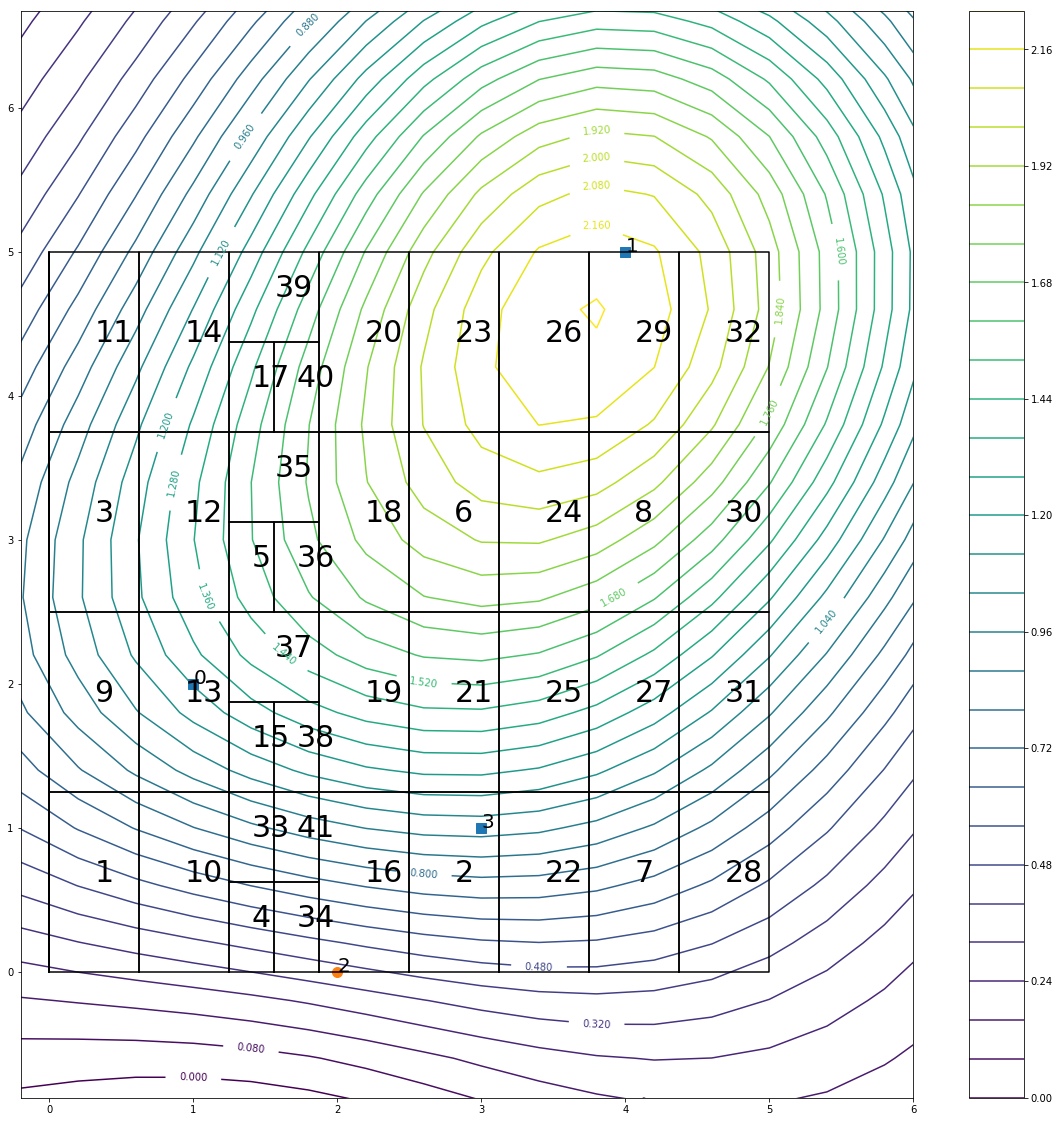

In [251]:
plt.figure(figsize=[20,20])
xs = np.arange(-1,10,0.4)
ys = np.arange(-1,10,0.4)
mg = np.array(np.meshgrid(xs,ys))
grid = np.array([mg[0].flatten(),mg[1].flatten()]).T
v = np.zeros([len(xs),len(ys)])
for eq,eqw in zip(EQcentres,EQweights):
    v += eqw*zeromean_gaussian(grid-eq,ls).reshape(len(xs),len(ys))
CS = plt.contour(xs,ys,v,30)
plt.clabel(CS, inline=1, fontsize=10)
plt.colorbar()



plt.plot(EQcentres[EQweights>0,0],EQcentres[EQweights>0,1],'s',markersize=10,label='positive')
plt.plot(EQcentres[EQweights<0,0],EQcentres[EQweights<0,1],'o',markersize=10,label='negative')
for i, c in enumerate(EQcentres):
    plt.text(c[0],c[1],i,fontsize=20)
#plt.legend()
for idx, (hypercube_start, hypercube_end) in enumerate(zip(hypercube_starts,hypercube_ends)):
    plt.plot([hypercube_start[0],hypercube_start[0],hypercube_end[0],hypercube_end[0],hypercube_start[0]],[hypercube_start[1],hypercube_end[1],hypercube_end[1],hypercube_start[1],hypercube_start[1]],'k-')
    if idx>0: plt.text((hypercube_start[0]+hypercube_end[0])/2,(hypercube_start[1]+hypercube_end[1])/2,idx,fontsize=30)
plt.axis('equal')
grid = np.arange(0,6)

#for i in range(len(EQweights)):
#    means = EQweights[i]*zeromean_gaussian_1d(grid-EQcentres[i,d],ls)
#    for g,m in zip(grid,means):
#        plt.text(g,i/4,"%0.2f" % m)
        

plt.xlim([-.2,6])
plt.ylim([-.2,6])

# Copy of above but 5d

In [258]:
ls = 2.0
diff_dim = 0

hypercube_starts = [np.array([0,0])*1.0,np.array([0,0])*1.0,np.array([0,0])*1.0,np.array([0,0])*1.0,np.array([0,0])*1.0]
hypercube_ends = [np.array([5,5])*1.0,np.array([5,5])*1.0,np.array([5,5])*1.0,np.array([5,5])*1.0,np.array([5,5])*1.0]
hypercube_ends[0][diff_dim] = 0
forwardpaths = [[1],[]]
backwardpaths = [[],[0]]

EQcentres = np.random.rand(100,5)*5
EQweights = np.random.randn(100)
innerchanges = None

In [259]:
split_index = 1
if innerchanges is not None:
    split_index = np.argmax(np.sum(np.abs(innerchanges),1))
split_dim = np.argmax(hypercube_ends[split_index]-hypercube_starts[split_index])
splitcubes(hypercube_starts,hypercube_ends,forwardpaths,backwardpaths,split_index,split_dim,diff_dim)

startchanges, midchanges, endchanges, innerchanges = getallchanges(EQcentres,EQweights,hypercube_starts,hypercube_ends,diff_dim,ls)
print(len(startchanges))

6


In [260]:
maxval = -np.inf
for p in paths:
    for start in range(1,len(p)):
        b = getbound(EQcentres,hypercube_starts[p[start]],hypercube_ends[p[start]],diff_dim,ls,innerchanges[p[start],:])
        maxval = max(b,maxval)
        print(start,start,p[start],p[start],innerchanges[p[start],:],b)
        for end in range(start+1,len(p)):
            changes = startchanges[p[start],:] + np.sum(midchanges[p[start+1:end],:],0) + endchanges[p[end],:]
            b = getbound(EQcentres,hypercube_starts[p[start]],hypercube_ends[p[end]],diff_dim,ls,changes)
            maxval = max(b,maxval)
            print(start,end,p[start:(end+1)],changes,b)
print("MAXIMUM CHANGE BOUND %0.3f" % maxval)

1 1 1 1 [ 0.03  0.09  0.04  0.    0.44 -0.39 -0.09  0.16  0.31  0.02  0.24 -0.09
  1.9   0.92  0.01  0.06 -0.29  1.02  0.07  0.01  0.7   0.57  0.01  0.03
  0.08  0.13  0.04  0.09  0.03  0.23  0.79  0.3   0.56 -0.32  1.44  0.23
  0.36  0.48  0.5   0.65 -0.24  0.75  0.02  0.33  0.08  0.69  0.49  0.26
  0.42  0.03  0.33  0.15  0.64  0.29  0.29 -0.99  0.04  0.38  0.08 -0.62
  0.4   0.01  0.49  0.55  0.61 -0.41  0.15  0.2   0.01  0.15  0.   -0.7
  0.11  0.3   0.05 -0.39  0.    0.02  0.02  0.    0.54  0.08 -0.34  1.13
 -0.18 -1.1   0.11  0.03  0.82  0.13  0.15 -0.52 -0.49  0.25  0.22  0.01
  0.4   0.4   0.33 -0.59] [7.32]


IndexError: index 10 is out of bounds for axis 0 with size 6

In [266]:
midchanges.shape

(6, 100)